In [ ]:
using GpABC, DifferentialEquations, Distances, Plots

# Rejection ABC using GaussProABC - estimating parameters

This notebook demonstrates how to perform simulation- and emulation-based rejection ABC using GaussProABC for parameter estimation of an ODE model.

Start by choosing some settings for ABC, the emulator and the toy, noise-free ODE system. There is also a wrapper function that returns the solution to the toy system for some given parameters and ODE solution options.

In [ ]:
#
# ABC settings
#
n_var_params = 2
n_particles = 1000
threshold = 0.5
priors = [Distributions.Uniform(0., 5.), Distributions.Uniform(0., 5.)]
distance_metric = euclidean
progress_every = 1000

#
# Emulation settings
#
n_design_points = 100
batch_size = 1000
max_iter = 1000

#
# True parameters
#
true_params =  [2.0, 1.0, 15.0, 1.0, 1.0, 1.0, 100.0, 1.0, 1.0, 1.0]

#
# ODE solver settings
#
Tspan = (0.0, 10.0)
x0 = [3.0, 2.0, 1.0]
solver = RK4()
saveat = 0.1

#
# Returns the solution to the toy model as solved by DifferentialEquations
#
GeneReg = function(params::AbstractArray{Float64,1},
    Tspan::Tuple{Float64,Float64}, x0::AbstractArray{Float64,1},
    solver::OrdinaryDiffEq.OrdinaryDiffEqAlgorithm, saveat::Float64)

  if size(params,1) != 10
    throw(ArgumentError("GeneReg needs 10 parameters, $(size(params,1)) were provided"))
  end

  function ODE_3GeneReg(dx, x, par, t)
    dx[1] = par[1]/(1+par[7]*x[3]) - par[4]*x[1]
    dx[2] = par[2]*par[8]*x[1]./(1+par[8]*x[1]) - par[5]*x[2]
    dx[3] = par[3]*par[9]*x[1]*par[10]*x[2]./(1+par[9]*x[1])./(1+par[10]*x[2]) - par[6]*x[3]
  end

  prob = ODEProblem(ODE_3GeneReg, x0 ,Tspan, params)
  Obs = solve(prob, solver, saveat=saveat)

  return Obs
end

(::#1) (generic function with 1 method)

## Plot reference data

The reference data is the concentrations over time for the three species. Computed by solving the model with the true parameters.

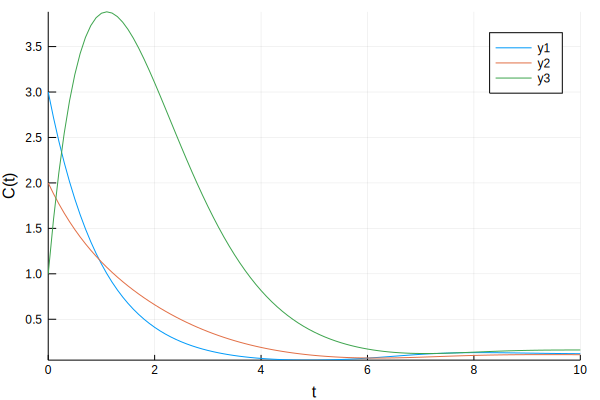

In [3]:
#
# Get reference data and plot it
#
reference_data = GeneReg(true_params, Tspan, x0, solver, saveat)
println("Got reference data")

plot(reference_data.t, transpose(hcat(reference_data.u...)), xlabel="t", ylabel="C(t)")


## Simulation-based rejection ABC

To perform rejection ABC, first construct an instance of one of either two objects: `SimulatedABCRejectionInput` or `EmulatedABCRejectionInput`.

The simulated version contains the number of accepted particles, acceptance threshold, priors, the distance metric and the simulator funciton. Note that this needs to be extended to include summary statistics.

The simulator function is user-defined and must to take the unknown parameters as a single argument and return the simluated trajectories.

After constructing the input object it is passed to `ABCrejection` with the reference (observed) data to perform rejection ABC.

In [4]:
#
# Simulation
#
simulator_function(var_params) = GeneReg(vcat(var_params, true_params[n_var_params+1:end]), Tspan, x0, solver, saveat)

sim_rej_input = SimulatedABCRejectionInput(n_var_params,
                        n_particles,
                        threshold,
                        priors,
                        distance_metric,
                        simulator_function)

sim_result = ABCrejection(sim_rej_input, reference_data, progress_every=progress_every)

2018-06-22T12:04:48.912 Accepted 18/1000 particles.
2018-06-22T12:04:49.043 Accepted 49/2000 particles.
2018-06-22T12:04:49.149 Accepted 81/3000 particles.
2018-06-22T12:04:49.26 Accepted 105/4000 particles.
2018-06-22T12:04:49.363 Accepted 131/5000 particles.
2018-06-22T12:04:49.468 Accepted 161/6000 particles.
2018-06-22T12:04:49.572 Accepted 186/7000 particles.
2018-06-22T12:04:49.683 Accepted 209/8000 particles.
2018-06-22T12:04:49.804 Accepted 226/9000 particles.
2018-06-22T12:04:49.906 Accepted 250/10000 particles.
2018-06-22T12:04:50.022 Accepted 268/11000 particles.
2018-06-22T12:04:50.133 Accepted 299/12000 particles.
2018-06-22T12:04:50.237 Accepted 318/13000 particles.
2018-06-22T12:04:50.343 Accepted 346/14000 particles.
2018-06-22T12:04:50.445 Accepted 373/15000 particles.
2018-06-22T12:04:50.551 Accepted 392/16000 particles.
2018-06-22T12:04:50.662 Accepted 405/17000 particles.
2018-06-22T12:04:50.766 Accepted 423/18000 particles.
2018-06-22T12:04:50.871 Accepted 441/1900

GpABC.ABCRejectionOutput(2, 1000, 41777, 0.5, [2.64009 0.948292; 2.22066 1.02977; … ; 2.44154 0.875271; 1.22273 1.07708], [0.262768, 0.144668, 0.226705, 0.32587, 0.456294, 0.416928, 0.44678, 0.392478, 0.154349, 0.459289  …  0.424305, 0.0787586, 0.341862, 0.466171, 0.220878, 0.313819, 0.359812, 0.445948, 0.426842, 0.385079], [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001  …  0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001])

## Emulation-based Rejection ABC

First train the emulator. This requires training inputs `X` and training outputs `y`, where `X` is an array with size (n_design_points, n_unknown_parameters) and `y` is an array with size (n_design_points).

The function `get_training_data` returns `X` and `y` in the correct format to be used with a `GPModel`.

Then train the model, plotting the design points and their distances.

Trained emulator


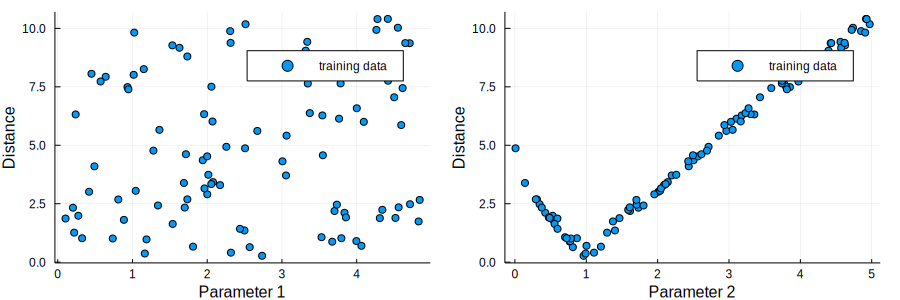

In [17]:
#
# Train the Emulator
#

#
# First prepare data for emulator - matrix X contains design ponts and y contains distances
#
function get_training_data(n_design_points,
  priors,
  simulator_function, distance_metric,
  reference_data)
    
  X = zeros(n_design_points, length(priors))
  y = zeros(n_design_points)  
  for i in 1:n_design_points
    dp = [rand(d) for d in priors]
    X[i,:] = dp
    y[i] = distance_metric(simulator_function(dp), reference_data)
  end
    
  return X, y
end

X, y = get_training_data(n_design_points, priors, simulator_function, distance_metric, reference_data)

#
# Train emulator - VARIANCE SEEMS SMALL
#
gpem = GPModel(training_x=X, training_y=y, kernel=SquaredExponentialArdKernel())
gp_train(gpem)

println("Trained emulator")

#
# Plot design points
#
plts = [scatter(X[:,idx], y, label="training data", xlabel="Parameter $idx", ylabel="Distance") for idx = 1:size(priors, 1)]
plot(plts..., size=(900, 300))

The second parameter is easier to pick up using this distance metric and summary statistic than the first.

When creating an `EmulatedABCRejectionInput` object provide a function that returns the emulated distances rather than the `simulator_function` required in the simulation case. Also provide a batch size and a maximum number of iterations.

In [6]:
#
# Use the emulator for rejection ABC
#
function predict_distance(p::AbstractArray{Float64})
    result = gp_regression(p,gpem)[1]
    return result
end

emu_rej_input = EmulatedABCRejectionInput(n_var_params,  
  n_particles,
  threshold,
  priors,
  predict_distance,
  batch_size,
  max_iter)

emu_result = ABCrejection(emu_rej_input, reference_data, progress_every=5)

2018-06-22T12:05:07.315 Accepted 100/5000 particles (5 batches of size 1000).
2018-06-22T12:05:07.372 Accepted 204/10000 particles (10 batches of size 1000).
2018-06-22T12:05:07.424 Accepted 307/15000 particles (15 batches of size 1000).
2018-06-22T12:05:07.482 Accepted 403/20000 particles (20 batches of size 1000).
2018-06-22T12:05:07.538 Accepted 509/25000 particles (25 batches of size 1000).
2018-06-22T12:05:07.592 Accepted 603/30000 particles (30 batches of size 1000).
2018-06-22T12:05:07.65 Accepted 692/35000 particles (35 batches of size 1000).
2018-06-22T12:05:07.706 Accepted 820/40000 particles (40 batches of size 1000).
2018-06-22T12:05:07.765 Accepted 930/45000 particles (45 batches of size 1000).


GpABC.ABCRejectionOutput(2, 1000, 49000, 0.5, [2.7384 0.989223; 1.67445 0.964518; … ; 2.70899 1.00262; 1.67751 1.04301], [0.445457, 0.32466, 0.357611, 0.454114, 0.352152, 0.35035, 0.471627, 0.480301, 0.459872, 0.488474  …  0.38452, 0.342976, 0.480753, 0.331791, 0.48091, 0.347475, 0.438598, 0.48388, 0.440087, 0.325104], [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001  …  0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001])

# Comparing the resulting posteriors from simulation and emulation

They are similar and both center on the correct parameter values.

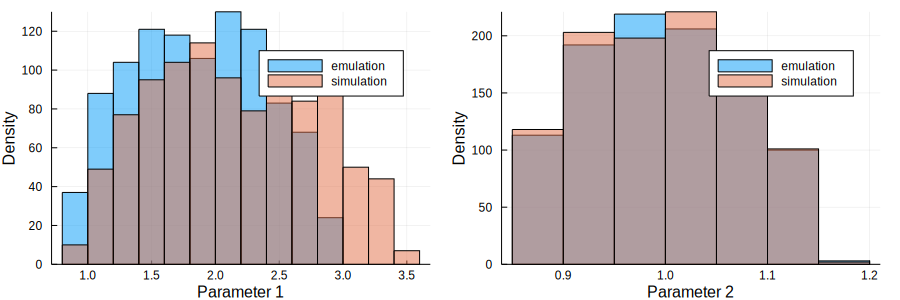

In [19]:
plts = Vector{Plots.Plot}(n_var_params)
for idx in 1:n_var_params
    plts[idx] = histogram([emu_result.population[:,idx] sim_result.population[:,idx]], 
        label=["emulation", "simulation"], fillalpha=0.5, xlabel="Parameter $idx", ylabel="Density")
end
plot(plts..., size=(900,300))

# ABC-SMC

In [ ]:
#
# ABC-SMC settings
#
threshold_schedule = [3.0, 2.0, 1.0]

3-element Array{Float64,1}:
 3.0
 2.0
 1.0

## Simulation-based ABC-SMC

In [9]:
sim_abcsmc_input = SimulatedABCSMCInput(n_var_params,
    n_particles,
    threshold_schedule,
    priors,
    distance_metric,
    simulator_function)

sim_abcsmc_res = ABCSMC(sim_abcsmc_input, reference_data)

2018-06-22T12:05:10.842 Accepted 351/1000 particles.
2018-06-22T12:05:10.945 Accepted 711/2000 particles.
2018-06-22T12:05:12.186 Accepted 627/1000 particles.
2018-06-22T12:05:13.086 Accepted 343/1000 particles.
2018-06-22T12:05:13.625 Accepted 649/2000 particles.
2018-06-22T12:05:14.212 Accepted 980/3000 particles.


GpABC.ABCSMCOutput(2, [1000, 1000, 1000], [2822, 1609, 3052], [3.0, 2.0, 1.0], Array{Float64,2}[[0.775494 1.58183; 2.90524 0.73466; … ; 4.4329 0.425486; 1.36825 1.26577], [1.39708 0.465931; 2.82937 0.6397; … ; 0.541247 1.60415; 1.13353 0.866429], [2.6225 0.830098; 3.37106 0.765403; … ; 1.01543 0.793346; 2.83259 0.72511]], Array{Float64,1}[[1.81456, 0.922706, 0.601753, 1.96898, 2.2624, 2.41216, 1.50483, 1.44361, 1.70179, 1.58804  …  2.53951, 1.974, 1.78663, 2.95828, 0.956424, 1.01217, 1.33823, 2.53397, 2.13346, 0.85577], [1.99796, 1.26275, 0.874352, 0.702555, 1.76613, 1.5756, 1.49116, 1.06548, 1.29329, 0.558109  …  1.94193, 1.03121, 1.46911, 1.68567, 0.813272, 0.514565, 0.856994, 0.444176, 1.90883, 0.638454], [0.585642, 0.854245, 0.622721, 0.894892, 0.968788, 0.425996, 0.515138, 0.390161, 0.499606, 0.347167  …  0.948222, 0.425444, 0.533141, 0.734615, 0.589419, 0.793346, 0.275792, 0.85848, 0.891763, 0.953447]], StatsBase.Weights[[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.

## Emulation-based ABC-SMC

In [10]:
emu_abcsmc_input = EmulatedABCSMCInput(n_var_params,
    n_particles,
    threshold_schedule,
    priors,
    predict_distance,
    batch_size,
    max_iter)

emu_abcsmc_res = ABCSMC(emu_abcsmc_input, reference_data)

2018-06-22T12:05:16.882 Accepted 580/1000 particles.
2018-06-22T12:05:17.787 Accepted 346/1000 particles.
2018-06-22T12:05:18.391 Accepted 684/2000 particles.


GpABC.ABCSMCOutput(2, [1000, 1000, 1000], [3000, 1743, 2921], [3.0, 2.0, 1.0], Array{Float64,2}[[2.37972 1.00617; 4.13078 1.27199; … ; 1.23793 1.74003; 0.651985 1.52867], [0.68836 0.99988; 2.27237 1.31564; … ; 4.64605 1.35279; 4.59225 0.634526], [1.85623 1.31311; 2.51034 1.28651; … ; 1.49243 1.26619; 2.55492 0.936664]], Array{Float64,1}[[0.370864, 1.28569, 1.83909, 0.633149, 0.561843, 2.23083, 1.41589, 0.903196, 2.12077, 1.67817  …  1.01491, 1.08812, 0.87367, 1.74738, 0.913594, 1.64697, 2.7682, 2.17676, 2.27879, 1.83143], [0.584453, 1.01686, 1.55243, 1.25108, 1.08866, 0.944944, 1.86073, 0.915893, 0.358239, 1.21339  …  0.740413, 1.45938, 0.605656, 1.34591, 0.99741, 1.42609, 0.957338, 1.25753, 1.57147, 1.35287], [0.965153, 0.963918, 0.744607, 0.693582, 0.393118, 0.882105, 0.411838, 0.781516, 0.32432, 0.333446  …  0.413399, 0.723341, 0.394081, 0.457407, 0.751313, 0.928143, 0.628435, 0.786852, 0.815176, 0.427879]], StatsBase.Weights[[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 

## Compare the posteriors

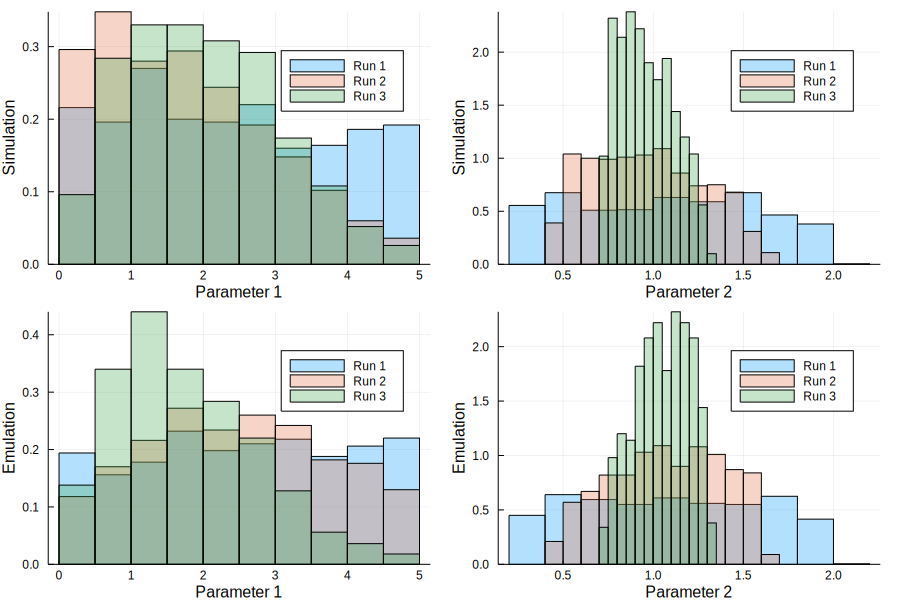

In [20]:
abcsmc_res = [sim_abcsmc_res, emu_abcsmc_res]
ylabels=["Simulation", "Emulation"]
plts = Vector{Plots.Plot}(n_var_params * 2)
idx = 1
for i in 1:2
    for j in 1:n_var_params
        hist_data = hcat([abcsmc_res[i].population[k][:,j] for k in 1:length(threshold_schedule)]...)
        labels = ["Run $k" for k in 1:length(threshold_schedule)]
        plts[idx] = histogram(hist_data, label=labels, fillalpha=0.3, 
            xlabel="Parameter $j", ylabel=ylabels[i], normed=true)
        idx += 1
    end
end
plot(plts..., size=(900,600))


In [12]:
size(abcsmc_res[1].population[end])

(1000, 2)